# Predictors for titanic
Data Analysis - ISAE 2018/2019 - Gauthier Le Moulec

In [1]:
import os #path handling
import numpy as np #import numpy drives sklearn to use numpy arrays instead of python lists
import pandas as pd #CSV and dataframe handling
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3D plots
from sklearn.linear_model import Perceptron #Perceptron classifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix #Confusion matrix
#inline plots for nicer viewing
%matplotlib inline 

In [2]:
dataFileTrain = 'train.csv'
dataFileTest = 'test.csv'
dataFileResult = 'gender_submission.csv'
print('train: ' + dataFileTrain + '\ntest: ' + dataFileTest + '\nresult: ' + dataFileResult)

train: train.csv
test: test.csv
result: gender_submission.csv


# 2) Data importing and formating

In [3]:
# we assign column names based on the description file.
fullDF = pd.read_csv(dataFileTrain,header= 1,names=['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']) 
testDFdata = pd.read_csv(dataFileTest,header=1,names=['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'])
testDFresult = pd.read_csv(dataFileResult,header=1,names=['PassengerId','Survived'])
testDFresult.drop('PassengerId',axis=1,inplace=True)
testDF = pd.concat([testDFdata, testDFresult], axis=1, join='inner', ignore_index=False)

testDF.head() # let's take a random sample from the full data frame train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
1,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
2,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
3,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
4,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0


In [4]:
fullDF.count()

PassengerId    890
Survived       890
Pclass         890
Name           890
Sex            890
Age            713
SibSp          890
Parch          890
Ticket         890
Fare           890
Cabin          204
Embarked       888
dtype: int64

In [5]:
testDF.count()

PassengerId    417
Pclass         417
Name           417
Sex            417
Age            331
SibSp          417
Parch          417
Ticket         417
Fare           416
Cabin           91
Embarked       417
Survived       417
dtype: int64

In [6]:
# Series no consequently described (i.e series with huge amount of NaN) aren't appropriate
countNaN = fullDF.isnull().sum()
countNaN

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          686
Embarked         2
dtype: int64

In [7]:
# Thus, 'Cabin' will not be conserved. 'Age' will be subject to further discussions (managing of NaN objects)
# 'Ticket','Name' and 'PAssengerId' can't be used as features too (difficulties to process String parameters.
fullDF.drop(['Cabin','Ticket','Name','PassengerId'],axis=1,inplace=True)
fullDF = fullDF.dropna()
testDF.drop(['Cabin','Ticket','Name','PassengerId'],axis=1,inplace=True)
testDF = testDF.dropna()
testDF.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,female,47.0,1,0,7.0000,S,1
1,2,male,62.0,0,0,9.6875,Q,0
2,3,male,27.0,0,0,8.6625,S,0
3,3,female,22.0,1,1,12.2875,S,1
4,3,male,14.0,0,0,9.2250,S,0


In [8]:
fullDF.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,female,38.0,1,0,71.2833,C
1,1,3,female,26.0,0,0,7.9250,S
2,1,1,female,35.0,1,0,53.1000,S
3,0,3,male,35.0,0,0,8.0500,S
5,0,1,male,54.0,0,0,51.8625,S


In [9]:
# Let's define a mapping function from 'Sex' to a class number
def dataMapS(Sex):
  """
  Data mapping function. Assigns a class number, given a class name
  Args:
    FType: (str) Sex
  Returns: (int) class
  """
  mapping = {'male': 0,
            'female': 1}
  return mapping[Sex]

In [10]:
# Let's define a mapping function from 'Sex' to a class number
def dataMapE(Embarked):
  """
  Data mapping function. Assigns a class number, given a class name
  Args:
    FType: (str) Embarked
  Returns: (int) class
  """
  mapping = {'Q': 0,
            'S': 1, 
            'C': 2}
  return mapping[Embarked]

In [11]:
# Let's apply the mapping function to the input data and replace the columns 'Sex' and 'Embarked'
fullDF['Sex'] = [dataMapS(item) for item in fullDF['Sex']]
fullDF['Embarked'] = [dataMapE(item) for item in fullDF['Embarked']]
testDF['Sex'] = [dataMapS(item) for item in testDF['Sex']]
testDF['Embarked'] = [dataMapE(item) for item in testDF['Embarked']]
testDF.sample(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
290,3,1,30.0,0,0,6.9500,0,1
36,3,1,21.0,0,0,8.6625,1,1
99,1,1,43.0,1,0,55.4417,2,1
17,3,1,27.0,1,0,7.9250,1,1
13,1,1,47.0,1,0,61.1750,1,1


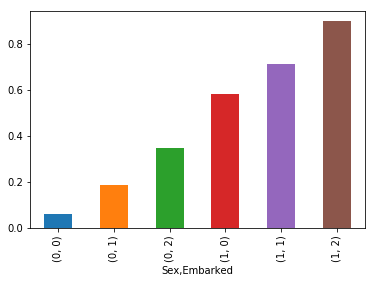

In [12]:
sex_embarked_grouping = fullDF.groupby(['Sex','Embarked']).mean()
sex_embarked_grouping['Survived'].plot.bar()

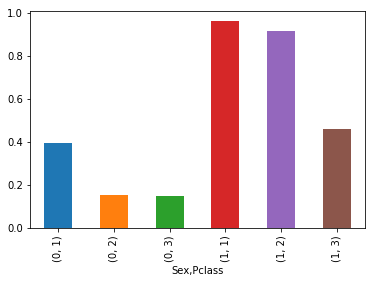

In [13]:
sex_Pclass_grouping = fullDF.groupby(['Sex','Pclass']).mean()
sex_Pclass_grouping['Survived'].plot.bar()

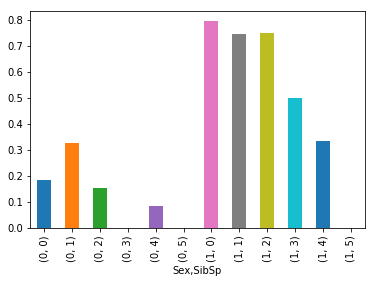

In [14]:
sex_SibSp_grouping = fullDF.groupby(['Sex','SibSp']).mean()
sex_SibSp_grouping['Survived'].plot.bar()

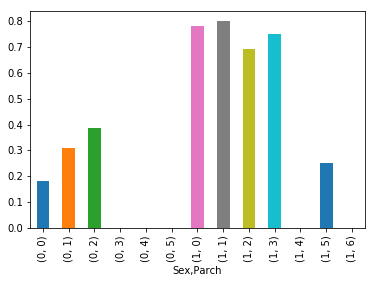

In [15]:
sex_Parch_grouping = fullDF.groupby(['Sex','Parch']).mean()
sex_Parch_grouping['Survived'].plot.bar()

# 3) Perceptron

In [16]:
dataX = fullDF[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
Y = fullDF['Survived']
testX = testDF[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
testY = testDF['Survived']

In [17]:
#testY.head()

In [18]:
#testX.head()

In [19]:
per = Perceptron(tol=0.001, random_state=0)
per.fit(dataX,Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=0.001, verbose=0, warm_start=False)

In [20]:
# Check the classifier's performance on the training data
trainPredictions = per.predict(dataX)
trainCM = confusion_matrix(y_pred=trainPredictions,y_true=Y)
print(trainCM)

[[317 106]
 [114 174]]


In [21]:
per.score(dataX,Y)

0.6905766526019691

In [22]:
testPredictions = per.predict(testX)
testCM = confusion_matrix(y_pred=testPredictions,y_true=testY)
print(testCM)

[[132  71]
 [ 53  74]]


In [23]:
per.score(testX,testY)

0.6242424242424243

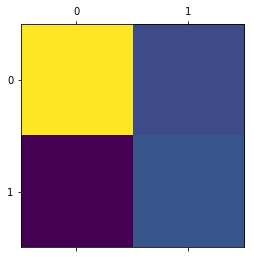

In [24]:
plt.matshow(testCM)

# 4) Multi-Layer Perceptron

In [25]:
dataX = fullDF[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
Y = fullDF['Survived']
testX = testDF[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
testY = testDF['Survived']

In [26]:
mlp = MLPClassifier(solver = 'adam',alpha=1e-5,max_iter = 400,hidden_layer_sizes=(5, 2),random_state=1)
mlp.fit(dataX,Y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [27]:
trainPredictions = mlp.predict(dataX)
trainCM = confusion_matrix(y_pred=trainPredictions,y_true=Y)
print(trainCM)

[[321 102]
 [ 65 223]]


In [28]:
mlp.score(dataX,Y)

0.7651195499296765

In [30]:
testPredictions = mlp.predict(testX)
testCM = confusion_matrix(y_pred=testPredictions,y_true=testY)
print(testCM)

[[142  61]
 [ 36  91]]


In [31]:
mlp.score(testX,testY)

0.706060606060606

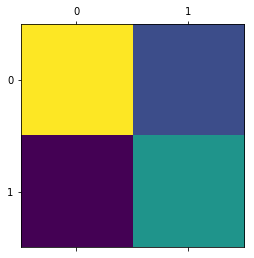

In [32]:
plt.matshow(testCM)

# 5) Decision Tree

In [33]:
dataX = fullDF[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
Y = fullDF['Survived']
testX = testDF[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
testY = testDF['Survived']

In [34]:
decisiontree = tree.DecisionTreeClassifier(max_depth=10)
decisiontree.fit(dataX,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
trainPredictions = decisiontree.predict(dataX)
trainCM = confusion_matrix(y_pred=trainPredictions,y_true=Y)
print(trainCM)

[[413  10]
 [ 40 248]]


In [36]:
decisiontree.score(dataX,Y)

0.929676511954993

In [39]:
testPredictions = decisiontree.predict(testX)
testCM = confusion_matrix(y_pred=testPredictions,y_true=testY)
print(testCM)

[[162  41]
 [ 33  94]]


In [40]:
decisiontree.score(testX,testY)

0.7757575757575758

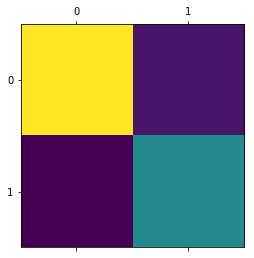

In [41]:
plt.matshow(testCM)